In [177]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def show_in_notebook(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

Find the labels

In [210]:
img = cv2.imread('../img/highres_board.png',1)
h, w, ch = img.shape
# Find the green labeled point
green_low = np.array([0, 220, 0])
green_high = np.array([10, 255, 10])
mask = cv2.inRange(img, green_low, green_high)

# coord contains all the pixel coordinates showing green color
coord = cv2.findNonZero(mask)
# convert coord to np_array format
coord_xy = [[dot[0][0],dot[0][1]] for dot in coord]
np_coord = np.array(coord_xy)

In [211]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(np_coord)

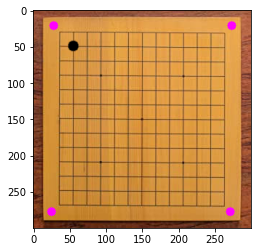

In [212]:
image = cv2.imread('../img/highres_board.jpeg')
for dot in kmeans.cluster_centers_:
    image = cv2.circle(image, (int(dot[0]),int(dot[1])), 6, (255, 0, 255), -1)
show_in_notebook(image)

In [213]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    rect[0] = pts[2]
    rect[1] = pts[0]
    rect[2] = pts[1]
    rect[3] = pts[3]
    return rect

Do Perspective Transformation

In [214]:
def four_point_transform(image, pts = kmeans.cluster_centers_):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

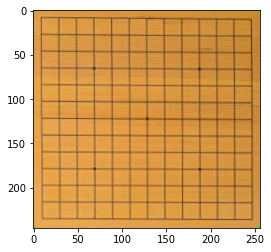

In [215]:
image = cv2.imread('../img/highres_board.png')
pts = kmeans.cluster_centers_
warped = four_point_transform(image, pts)
show_in_notebook(warped)

In [216]:
newbaseImg = warped.copy()

Find Edges in Rectified Image

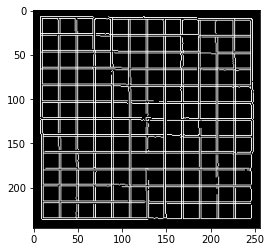

In [217]:
gray = cv2.cvtColor(newbaseImg, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,110,320,apertureSize = 3)
show_in_notebook(edges)

Hough Transformation To Find Lines

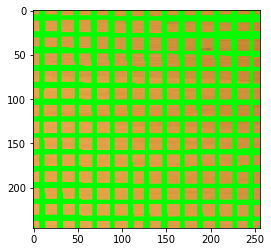

In [218]:
lines = cv2.HoughLines(edges,1,np.pi/180,110)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(newbaseImg,(x1,y1),(x2,y2),(0,255,0),2)

show_in_notebook(newbaseImg)

Group Vertical and Horizontal Lines

In [219]:
hori = []
verti = []

for line in lines:
    rho, theta = line[0]
    if theta <= 1.8 and theta >= 1.2:
        verti.append(line)
    else:
        hori.append(line)

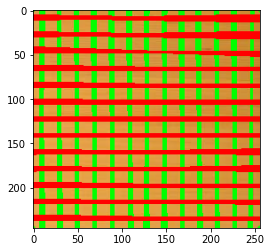

In [220]:
newbaseImg = warped.copy()

for line in hori:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(newbaseImg,(x1,y1),(x2,y2),(0,255,0),2)
for line in verti:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    cv2.line(newbaseImg,(x1,y1),(x2,y2),(0,0,255),2)
show_in_notebook(newbaseImg)

Find Intersections

In [221]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

intersections = []
for xline in hori:
    for yline in verti:
        intersections.append(intersection(xline, yline))

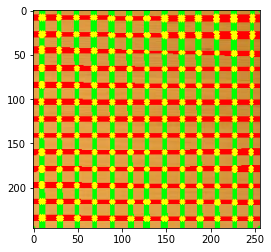

In [222]:
for intersect in intersections:
    x0 = intersect[0]
    y0 = intersect[1]

    img = cv2.circle(newbaseImg, (x0, y0), radius=2, color=(0, 255, 255), thickness=-1)
show_in_notebook(newbaseImg)

KMeans To Find Accurate Intersection Position

In [223]:
from sklearn.cluster import KMeans
X = np.array(intersections)
kmeans = KMeans(n_clusters=169, random_state=0).fit(X)

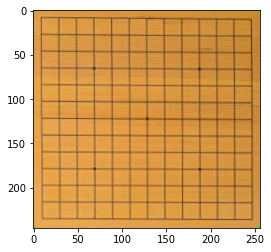

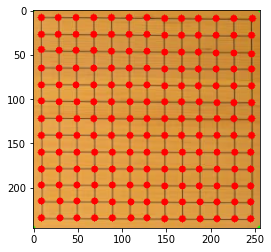

In [224]:
newbaseImg = warped.copy()
show_in_notebook(newbaseImg)
coord_array = np.array([[int(x[0]),int(x[1])] for x in kmeans.cluster_centers_])
for center in coord_array:
    img = cv2.circle(newbaseImg, [int(center[0]), int(center[1])], 4, (0,0,255), -1)
show_in_notebook(newbaseImg)

In [225]:
coord_array

array([[  9,  65],
       [128, 122],
       [186,  28],
       [110, 234],
       [245, 198],
       [ 29, 197],
       [ 88,  65],
       [187, 160],
       [ 89, 160],
       [206,  85],
       [128,   8],
       [ 28,   8],
       [188, 216],
       [128,  65],
       [ 29, 103],
       [246,  28],
       [128, 179],
       [  9, 160],
       [ 68,   8],
       [226, 141],
       [ 69, 215],
       [148,  85],
       [148, 216],
       [ 49, 141],
       [ 30, 234],
       [ 48,  65],
       [246, 104],
       [167, 141],
       [108,  84],
       [ 88, 103],
       [187, 179],
       [227, 235],
       [186,  85],
       [186,   9],
       [ 68,  27],
       [ 69, 179],
       [207, 179],
       [108,   8],
       [167,  47],
       [187, 103],
       [226,  66],
       [  9, 215],
       [148,  28],
       [108,  46],
       [168, 235],
       [110, 216],
       [148, 160],
       [  9, 102],
       [ 29,  45],
       [ 28,  27],
       [226,   9],
       [ 68, 103],
       [167,

In [226]:
sorted_cord = coord_array[coord_array[:,0].argsort()]
coord_lookup = []

for i in range(13):
    row_sorted = sorted_cord[13*i:13*i+13]
    rc_sorted = row_sorted[row_sorted[:,1].argsort()]
    x_row = []
    for j in range(13):
        x_row.append(rc_sorted[j])
    coord_lookup.append(x_row)
coord_lookup = np.array(coord_lookup)

<h3>Processing Step Image and Get Coordinate Color


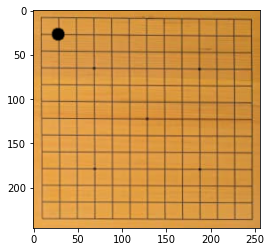

In [195]:
# step1 = cv2.imread('../img/step/step1.png')
# step1_warped = four_point_transform(step1, pts)
# show_in_notebook(step1_warped)
# r = 7


In [196]:
# def get_stone_mask(center_x, center_y, r, step_board):
#     roi = step1_warped[center_y - r: center_y + r, center_x - r: center_x + r]
#     width, height = roi.shape[:2]
#     mask = np.zeros((width, height, 3), roi.dtype)
#     cv2.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)
#     dst = cv2.bitwise_and(roi, mask)
#
# def read_stones(step_board):
#     full_board = np.zeros((13, 13))
#
#     for i in range(13):
#         for j in range(13):
#             x, y = coord_lookup[str(i)+','+str(j)]

In [197]:
# full_board = np.zeros((13, 13))
# for i in range(13):
#     for j in range(13):
#         x, y = coord_lookup[str(i)+','+str(j)]
#         roi = step1_warped[y - r: y + r, x - r: x + r]
#         show_in_notebook(roi)
#         width, height = roi.shape[:2]
#         mask = np.zeros((width, height, 3), roi.dtype)
#         cv2.circle(mask, (int(width / 2), int(height / 2)), r, (255, 255, 255), -1)
#         dst = cv2.bitwise_and(roi, mask)
#         data = []
#         for k in range(3):
#             channel = dst[:, :, k]
#             indices = np.where(channel != 0)[0]
#             color = np.mean(channel[indices])
#             data.append(int(color))
#         if sum(data)/len(data) < 50:
#             full_board[i][j] = 1
#         elif sum(data)/len(data) > 200:
#             full_board[i][j] = 2
#         else:
#             full_board[i][j] = 0
# full_board

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [227]:
mean_row = []
for row in coord_lookup:
    row_sum = sum(row[:, 0])
    mean_row.append(row_sum//13)

In [228]:
mean_col = []
for i in range(13):
    col = coord_lookup[:, i]
    col_sum = sum(col[:, 1])
    mean_col.append(col_sum//13)

<h2> Apply to 4th step image

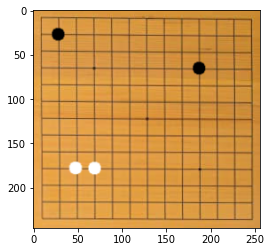

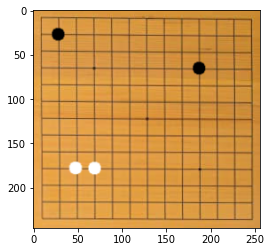

In [229]:
step4 = cv2.imread('../img/step/step4.png')
step4_warped = four_points_transform(step4, pts)
step4_warped_cp = step4_warped.copy()
show_in_notebook(step4_warped)
show_in_notebook(step4_warped_cp)
r = 7

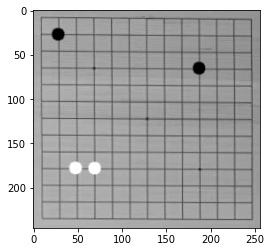

In [230]:
gray = cv2.cvtColor(step4_warped, cv2.COLOR_BGR2GRAY)

show_in_notebook(gray)

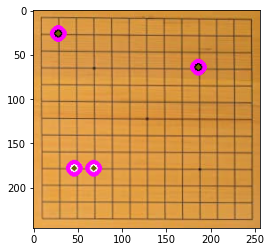

In [231]:
rows = gray.shape[0]
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 19,
                           param1=100, param2=15,
                           minRadius=5, maxRadius=10)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(step4_warped, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv2.circle(step4_warped, center, radius, (255, 0, 255), 3)
show_in_notebook(step4_warped)

In [232]:
stone_map = np.zeros((13, 13))

for circle in circles[0, :]:

    row_val = circle[0]
    col_val = circle[1]

    row_index = -1
    col_index = -1


    for i in range(len(mean_row)):
        if abs(row_val - mean_row[i]) <= 8:
            row_index = i
            break
    for i in range(len(mean_col)):
        if abs(col_val - mean_col[i]) <= 8:
            col_index = i
            break


    real_row, real_col = coord_lookup[row_index, col_index]

    grayscale = gray[real_row, real_col]
    print(grayscale)

154
172
0
149
